In [1]:
# imports
import h2o 
import numpy as np
import pandas as pd
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.grid.grid_search import H2OGridSearch

In [2]:
# display matplotlib graphics in notebook
%matplotlib inline

In [3]:
# start and connect to h2o server
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_112"; Java(TM) SE Runtime Environment (build 1.8.0_112-b16); Java HotSpot(TM) 64-Bit Server VM (build 25.112-b16, mixed mode)
  Starting server from /Users/phall/anaconda/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmphz2effjk
  JVM stdout: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmphz2effjk/h2o_phall_started_from_python.out
  JVM stderr: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmphz2effjk/h2o_phall_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster version:,3.11.0.3873
H2O cluster version age:,5 days
H2O cluster name:,H2O_from_python_phall_2pck4i
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


In [4]:
# load clean data
path = 'https://raw.githubusercontent.com/h2oai/app-consumer-loan/master/data/loan.csv'

In [5]:
# define input variable measurement levels 
# strings automatically parsed as enums (nominal)
# numbers automatically parsed as numeric
col_types = {'bad_loan': 'enum'}

In [6]:
frame = h2o.import_file(path=path, col_types=col_types) # import from url

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [7]:
frame.describe() # summarize data

Rows:163987
Cols:15




,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,revol_util,total_acc,bad_loan,longest_credit_length,verification_status
type,int,enum,real,int,enum,real,enum,enum,real,int,real,int,enum,int,enum
mins,500.0,,5.42,0.0,,1896.0,,,0.0,0.0,0.0,1.0,,0.0,
mean,13074.169141456332,,13.715904065566189,5.684352932995338,,71915.67051974905,,,15.881530121290167,0.22735700606252723,54.07917280242262,24.579733834274574,,14.854273655448333,
maxs,35000.0,,26.060000000000002,10.0,,7141778.0,,,39.99,29.0,150.70000000000002,118.0,,65.0,
sigma,7993.556188734672,,4.391939870545809,3.610663731100238,,59070.91565491818,,,7.5876682241925355,0.6941679229284191,25.285366766770498,11.685190365910666,,6.947732922546689,
zeros,0,,0,14248,,0,,,270,139459,1562,0,,11,
missing,0,0,0,5804,0,4,0,0,0,29,193,29,0,29,0
0,5000.0,36 months,10.65,10.0,RENT,24000.0,credit_card,AZ,27.650000000000002,0.0,83.7,9.0,0,26.0,verified
1,2500.0,60 months,15.27,0.0,RENT,30000.0,car,GA,1.0,0.0,9.4,4.0,1,12.0,verified
2,2400.0,36 months,15.96,10.0,RENT,12252.0,small_business,IL,8.72,0.0,98.5,10.0,0,10.0,not verified


In [8]:
# split into 40% training, 30% validation, and 30% test
train, valid, test = frame.split_frame([0.4, 0.3])

In [9]:
# assign target and inputs
y = 'bad_loan'
X = [name for name in frame.columns if name != y]
print(y)
print(X)

bad_loan
['loan_amnt', 'term', 'int_rate', 'emp_length', 'home_ownership', 'annual_inc', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'revol_util', 'total_acc', 'longest_credit_length', 'verification_status']


In [10]:
# determine column types
reals, enums = [], []
for key, val in frame.types.items():
    if key in X:
        if val == 'enum':
            enums.append(key)
        else: 
            reals.append(key)

print(enums)
print(reals)

['verification_status', 'purpose', 'addr_state', 'term', 'home_ownership']
['dti', 'loan_amnt', 'delinq_2yrs', 'emp_length', 'annual_inc', 'total_acc', 'revol_util', 'int_rate', 'longest_credit_length']


In [11]:
# impute missing values
_ = frame[reals].impute(method='mean')

In [12]:
# set target to factor - for binary classification
# just to be safe ...
train[y] = train[y].asfactor()
valid[y] = valid[y].asfactor()
test[y] = test[y].asfactor()

In [13]:
# neural network

# initialize nn model
nn_model = H2ODeepLearningEstimator(
    epochs=50,                    # read over the data 50 times, but in mini-batches
    hidden=[100],                 # 100 hidden units in 1 hidden layer
    input_dropout_ratio=0.2,      # randomly drop 20% of inputs for each iteration, helps w/ generalization
    hidden_dropout_ratios=[0.05], # randomly set 5% of hidden weights to 0 each iteration, helps w/ generalization
    activation='TanhWithDropout', # bounded activation function that allows for dropout, tanh
    l1=0.001,                     # L1 penalty can help generalization   
    l2=0.01,                      # L2 penalty can increase stability in presence of highly correlated inputs
    adaptive_rate=True,           # adjust magnitude of weight updates automatically (+stability, +accuracy)
    stopping_rounds=5,            # stop after validation error does not decrease for 5 iterations
    score_each_iteration=True,    # score validation error on every iteration
    model_id='nn_model')          # for easy lookup in flow

# train nn model
nn_model.train(
    x=X,
    y=y,
    training_frame=train,
    validation_frame=valid)

# print model information
nn_model

# view detailed results at http://localhost:54321/flow/index.html

deeplearning Model Build progress: |██████████████████████████████████████| 100%
Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  nn_model


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1380375047958179
RMSE: 0.37153398874910204
LogLoss: 0.4396046196810304
Mean Per-Class Error: 0.3538137602514768
AUC: 0.6941815465016488
Gini: 0.3883630930032975
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20441792771886222: 


,0,1,Error,Rate
0,5375.0,2740.0,0.3376,(2740.0/8115.0)
1,672.0,1125.0,0.374,(672.0/1797.0)
Total,6047.0,3865.0,0.3442,(3412.0/9912.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2044179,0.3973861,234.0
max f2,0.1321477,0.5573010,313.0
max f0point5,0.3071689,0.3648435,146.0
max accuracy,0.5201248,0.8196126,26.0
max precision,0.5818115,0.6111111,7.0
max recall,0.0539623,1.0,396.0
max specificity,0.6351689,0.9998768,0.0
max absolute_mcc,0.2571728,0.2369136,184.0
max min_per_class_accuracy,0.1989340,0.6421814,239.0
max mean_per_class_accuracy,0.1883191,0.6461862,251.0


Gains/Lift Table: Avg response rate: 18.13 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100888,0.5234928,2.8130885,2.8130885,0.51,0.51,0.0283806,0.0283806,181.3088481,181.3088481
,2,0.0200767,0.4922781,2.6743563,2.7440709,0.4848485,0.4974874,0.0267112,0.0550918,167.4356250,174.4070939
,3,0.0300646,0.4702215,2.0614829,2.5173051,0.3737374,0.4563758,0.0205899,0.0756817,106.1482943,151.7305128
,4,0.0400525,0.4478858,2.2286302,2.4453182,0.4040404,0.4433249,0.0222593,0.0979410,122.8630209,144.5318184
,5,0.0500404,0.4292794,1.7271884,2.3019818,0.3131313,0.4173387,0.0172510,0.1151920,72.7188412,130.1981798
,6,0.1000807,0.3628196,2.0017233,2.1518525,0.3629032,0.3901210,0.1001669,0.2153589,100.1723302,115.1852550
,7,0.1500202,0.3154801,1.9723377,2.0920948,0.3575758,0.3792872,0.0984975,0.3138564,97.2337735,109.2094760
,8,0.2000605,0.2805993,1.6013786,1.9693539,0.2903226,0.3570348,0.0801336,0.3939900,60.1378642,96.9353865
,9,0.3000404,0.2352909,1.2690374,1.7359935,0.2300706,0.3147276,0.1268781,0.5208681,26.9037363,73.5993524
,10,0.4000202,0.2009129,1.1521523,1.5900700,0.2088799,0.2882724,0.1151920,0.6360601,15.2152343,59.0070041




ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.14108077541655478
RMSE: 0.3756072089517915
LogLoss: 0.4470906628254785
Mean Per-Class Error: 0.36296444363355373
AUC: 0.6898250250972519
Gini: 0.3796500501945037
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19703728750638447: 


,0,1,Error,Rate
0,25220.0,14625.0,0.367,(14625.0/39845.0)
1,3273.0,5847.0,0.3589,(3273.0/9120.0)
Total,28493.0,20472.0,0.3655,(17898.0/48965.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1970373,0.3951744,244.0
max f2,0.1232002,0.5651465,326.0
max f0point5,0.2972181,0.3600982,158.0
max accuracy,0.5190178,0.8144389,31.0
max precision,0.6683965,1.0,0.0
max recall,0.0465019,1.0,399.0
max specificity,0.6683965,1.0,0.0
max absolute_mcc,0.2351344,0.2202635,210.0
max min_per_class_accuracy,0.1983460,0.6358553,243.0
max mean_per_class_accuracy,0.1970373,0.6370356,244.0


Gains/Lift Table: Avg response rate: 18.63 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100071,0.5217978,2.8597979,2.8597979,0.5326531,0.5326531,0.0286184,0.0286184,185.9797932,185.9797932
,2,0.0200143,0.4857599,2.4324718,2.6461349,0.4530612,0.4928571,0.0243421,0.0529605,143.2471805,164.6134868
,3,0.0300010,0.4598724,2.3715693,2.5547376,0.4417178,0.4758339,0.0236842,0.0766447,137.1569261,155.4737603
,4,0.0400082,0.4402436,2.2023731,2.4666015,0.4102041,0.4594181,0.0220395,0.0986842,120.2373120,146.6601515
,5,0.0500153,0.4233781,1.9832315,2.3698880,0.3693878,0.4414047,0.0198465,0.1185307,98.3231516,136.9888041
,6,0.1000102,0.3599212,1.9344081,2.1521925,0.3602941,0.4008577,0.0967105,0.2152412,93.4408056,115.2192512
,7,0.1500051,0.3158305,1.7107010,2.0050487,0.3186275,0.3734513,0.0855263,0.3007675,71.0701002,100.5048711
,8,0.2,0.2832035,1.5462105,1.8903509,0.2879902,0.3520882,0.0773026,0.3780702,54.6210521,89.0350877
,9,0.3000102,0.2359011,1.3277153,1.7027929,0.2472943,0.3171545,0.1327851,0.5108553,32.7715299,70.2792918
,10,0.4,0.2020730,1.0987964,1.5518092,0.2046569,0.2890330,0.1098684,0.6207237,9.8796413,55.1809211



Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_lift,validation_classification_error
,2017-05-15 16:39:49,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
,2017-05-15 16:39:50,2.608 sec,61197 obs/sec,1.5238415,1,99996.0,0.3727570,0.4419383,0.6847469,2.8130885,0.3624899,0.3763097,0.4485279,0.6853210,2.7611842,0.3504953
,2017-05-15 16:39:52,4.131 sec,71147 obs/sec,3.0488258,2,200067.0,0.3744362,0.4461478,0.6918143,2.7579299,0.3465496,0.3777867,0.4522231,0.6883249,2.7283130,0.3691821
,2017-05-15 16:39:54,5.697 sec,75635 obs/sec,4.5735359,3,300120.0,0.3715787,0.4399705,0.6888684,2.9785643,0.2997377,0.3758169,0.4475459,0.6884435,2.7830984,0.3295824
,2017-05-15 16:39:55,7.178 sec,77923 obs/sec,6.1012481,4,400370.0,0.3714534,0.4390695,0.6937255,2.8130885,0.3128531,0.3757799,0.4472347,0.6911982,2.7830984,0.3381599
,2017-05-15 16:39:57,8.669 sec,79216 obs/sec,7.6281373,5,500566.0,0.3724517,0.4415186,0.6920737,2.8130885,0.3248588,0.3763954,0.4485860,0.6885814,2.8050125,0.3432452
,2017-05-15 16:39:59,10.419 sec,77828 obs/sec,9.1537922,6,600681.0,0.3713727,0.4391898,0.6927701,2.9785643,0.3230428,0.3759861,0.4478243,0.6886940,2.8269267,0.3406719
,2017-05-15 16:40:01,12.397 sec,75525 obs/sec,10.6784109,7,700728.0,0.3737569,0.4419366,0.6943607,2.5372955,0.3768160,0.3775608,0.4494821,0.6902037,2.7392701,0.3634229
,2017-05-15 16:40:02,14.306 sec,74429 obs/sec,12.1974978,8,800412.0,0.3715340,0.4396046,0.6941815,2.8130885,0.3442292,0.3756072,0.4470907,0.6898250,2.8597979,0.3655264
,2017-05-15 16:40:04,16.008 sec,74065 obs/sec,13.7168437,9,900113.0,0.3716283,0.4398180,0.6897160,3.0337229,0.3465496,0.3758527,0.4474328,0.6873091,2.7502271,0.3459001


In [14]:
# measure nn AUC
print(nn_model.auc(train=True))
print(nn_model.auc(valid=True))
print(nn_model.model_performance(test_data=test).auc())

0.6941815465016488
0.6898250250972519
0.6993473693306903


In [15]:
# NN with random hyperparameter search
# train many different NN models with random hyperparameters
# and select best model based on validation error

# define random grid search parameters
hyper_parameters = {'hidden':[[170, 320], [80, 190], [320, 160, 80], [100], [50, 50, 50, 50]],
                    'l1':[s/1e4 for s in range(0, 1000, 100)],
                    'l2':[s/1e5 for s in range(0, 1000, 100)],
                    'input_dropout_ratio':[s/1e2 for s in range(0, 20, 2)]}

# define search strategy
search_criteria = {'strategy':'RandomDiscrete',
                   'max_models':20,
                   'max_runtime_secs':600}

# initialize grid search
gsearch = H2OGridSearch(H2ODeepLearningEstimator,
                        hyper_params=hyper_parameters,
                        search_criteria=search_criteria)

# execute training w/ grid search
gsearch.train(x=X,
              y=y,
              training_frame=train,
              validation_frame=valid)

# view detailed results at http://ip:port/flow/index.html

deeplearning Grid Build progress: |███████████████████████████████████████| 100%


In [16]:
# show grid search results
gsearch.show()

# select best model
nn_model2 = gsearch.get_grid()[0]

# print model information
nn_model2

                hidden input_dropout_ratio    l1     l2  \
0                [100]                0.14   0.0  0.006   
1                [100]                 0.1   0.0  0.001   
2           [170, 320]                0.14   0.0  0.006   
3                [100]                0.08   0.0  0.005   
4       [320, 160, 80]                0.08  0.09  0.003   
5       [320, 160, 80]                 0.1  0.09  0.002   
6     [50, 50, 50, 50]                0.14  0.08  0.006   
7       [320, 160, 80]                0.18  0.06  0.008   
8           [170, 320]                0.12  0.06  0.002   
9     [50, 50, 50, 50]                0.14  0.05  0.003   
10               [100]                0.18  0.05  0.005   
11    [50, 50, 50, 50]                0.18  0.08  0.008   
12          [170, 320]                0.02  0.06  0.008   
13          [170, 320]                0.12  0.05  0.004   
14      [320, 160, 80]                0.18  0.01  0.003   
15           [80, 190]                0.02  0.06  0.002 

,0,1,Error,Rate
0,5666.0,2494.0,0.3056,(2494.0/8160.0)
1,690.0,1155.0,0.374,(690.0/1845.0)
Total,6356.0,3649.0,0.3182,(3184.0/10005.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1868445,0.4204587,214.0
max f2,0.1022296,0.5741842,308.0
max f0point5,0.2917345,0.3773190,116.0
max accuracy,0.4371641,0.8174913,23.0
max precision,0.6341144,1.0,0.0
max recall,0.0148853,1.0,396.0
max specificity,0.6341144,1.0,0.0
max absolute_mcc,0.1868445,0.2581240,214.0
max min_per_class_accuracy,0.1744637,0.6542005,226.0
max mean_per_class_accuracy,0.1868445,0.6601895,214.0


Gains/Lift Table: Avg response rate: 18.44 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100950,0.4349336,3.2214441,3.2214441,0.5940594,0.5940594,0.0325203,0.0325203,222.1444096,222.1444096
,2,0.0200900,0.4107279,2.6029268,2.9137241,0.48,0.5373134,0.0260163,0.0585366,160.2926829,191.3724063
,3,0.0300850,0.3928956,2.1691057,2.6663425,0.4,0.4916944,0.0216802,0.0802168,116.9105691,166.6342544
,4,0.0400800,0.3789834,2.2775610,2.5693895,0.42,0.4738155,0.0227642,0.1029810,127.7560976,156.9389534
,5,0.0500750,0.3656629,1.8979675,2.4353732,0.35,0.4491018,0.0189702,0.1219512,89.7967480,143.5373156
,6,0.1000500,0.3161233,2.1148780,2.2752857,0.39,0.4195804,0.1056911,0.2276423,111.4878049,127.5285690
,7,0.1500250,0.2815499,1.8545854,2.1351457,0.342,0.3937375,0.0926829,0.3203252,85.4585366,113.5145675
,8,0.2,0.2541969,1.5726016,1.9945799,0.29,0.3678161,0.0785908,0.3989160,57.2601626,99.4579946
,9,0.3000500,0.2101233,1.3543367,1.7810944,0.2497502,0.3284477,0.1355014,0.5344173,35.4336720,78.1094447
,10,0.4,0.1743600,1.1875854,1.6327913,0.219,0.3010995,0.1186992,0.6531165,18.7585366,63.2791328




ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.14069388014796538
RMSE: 0.37509182895387816
LogLoss: 0.4449885819273104
Mean Per-Class Error: 0.3612160636721682
AUC: 0.6943229163226803
Gini: 0.38864583264536057
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18795709300022173: 


,0,1,Error,Rate
0,27455.0,12390.0,0.311,(12390.0/39845.0)
1,3779.0,5341.0,0.4144,(3779.0/9120.0)
Total,31234.0,17731.0,0.3302,(16169.0/48965.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1879571,0.3978250,209.0
max f2,0.1013624,0.5661065,305.0
max f0point5,0.2670322,0.3631317,138.0
max accuracy,0.4468096,0.8146431,25.0
max precision,0.5832048,1.0,0.0
max recall,0.0098585,1.0,397.0
max specificity,0.5832048,1.0,0.0
max absolute_mcc,0.2371701,0.2261680,163.0
max min_per_class_accuracy,0.1724778,0.6364035,225.0
max mean_per_class_accuracy,0.1651319,0.6387839,232.0


Gains/Lift Table: Avg response rate: 18.63 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100071,0.4365156,2.8050125,2.8050125,0.5224490,0.5224490,0.0280702,0.0280702,180.5012531,180.5012531
,2,0.0200143,0.4090231,2.4105576,2.6077851,0.4489796,0.4857143,0.0241228,0.0521930,141.0557644,160.7785088
,3,0.0300010,0.3899283,2.2398154,2.4852955,0.4171779,0.4628999,0.0223684,0.0745614,123.9815413,148.5295523
,4,0.0400082,0.3757365,2.1147165,2.3926035,0.3938776,0.4456355,0.0211623,0.0957237,111.4716479,139.2603470
,5,0.0500153,0.3626007,2.3009868,2.3742727,0.4285714,0.4422213,0.0230263,0.11875,130.0986842,137.4272662
,6,0.1000102,0.3150706,1.9366013,2.1554817,0.3607026,0.4014703,0.0968202,0.2155702,93.6601262,115.5481650
,7,0.1500051,0.2803658,1.7655312,2.0255159,0.3288399,0.3772634,0.0882675,0.3038377,76.5531162,102.5515851
,8,0.2,0.2520280,1.6032339,1.9199561,0.2986111,0.3576024,0.0801535,0.3839912,60.3233888,91.9956140
,9,0.3000102,0.2087785,1.2871493,1.7090062,0.2397386,0.3183118,0.1287281,0.5127193,28.7149266,70.9006156
,10,0.4,0.1755280,1.1218251,1.5622259,0.2089461,0.2909731,0.1121711,0.6248904,12.1825080,56.2225877



Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_lift,validation_classification_error
,2017-05-15 16:40:51,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
,2017-05-15 16:40:52,37.072 sec,121295 obs/sec,1.0,1,65621.0,0.3920232,0.5059243,0.7003440,2.9529904,0.3082459,0.3948415,0.5146011,0.6901449,2.8159696,0.3447769
,2017-05-15 16:40:56,40.812 sec,162589 obs/sec,10.0,10,656210.0,0.3709774,0.4356662,0.7116647,3.2214441,0.3182409,0.3750918,0.4449886,0.6943229,2.8050125,0.3302155


In [17]:
# measure nn AUC
print(nn_model2.auc(train=True))
print(nn_model2.auc(valid=True))
print(nn_model2.model_performance(test_data=test).auc())

0.7116646739996811
0.6943229163226803
0.7057503904349255


PartialDependencePlot progress: |█████████████████████████████████████████| 100%


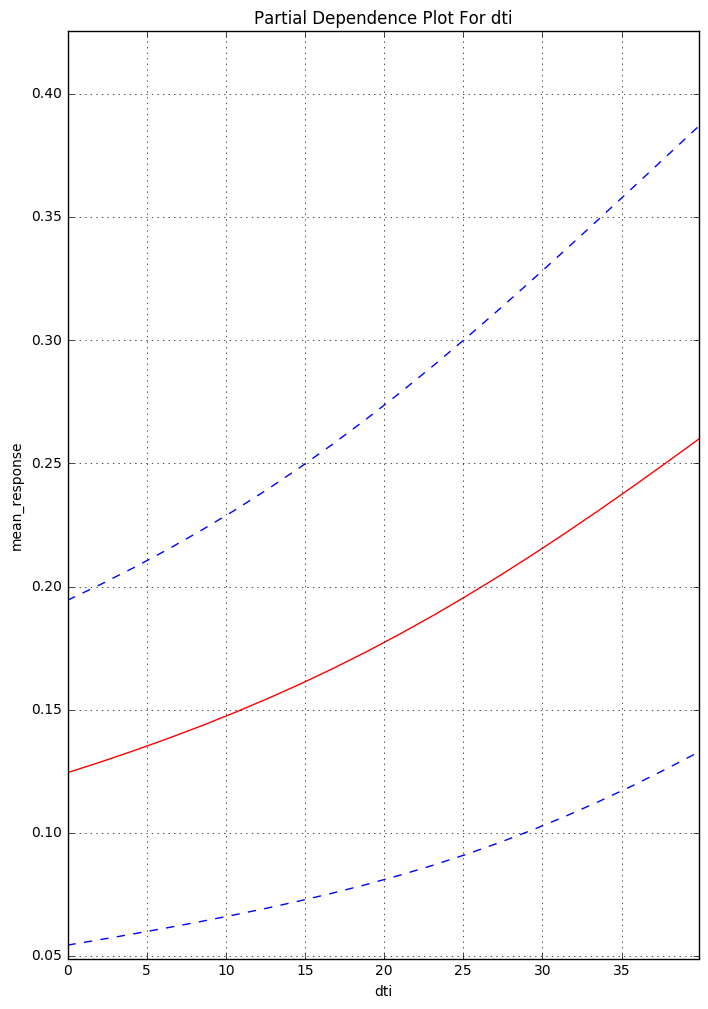

In [18]:
# partial dependence plots are a powerful machine learning interpretation tool
# to calculate partial dependence across the domain a variable
# hold column of interest at constant value
# find the mean prediction of the model with this column constant
# repeat for multiple values of the variable of interest
# h2o has a built-in function for partial dependence as well
par_dep_dti1 = nn_model2.partial_plot(data=train, cols=['dti'], server=True, plot=True)

In [19]:
# shutdown h2o
# be careful ... this can erase your work
# h2o.cluster().shutdown(prompt=True)